### This notebook is an extension of 08.Federated_Learning_with_Testing_and_model_saving and shows how to use a saved model to perform prediction on a test set

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

import h5py

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
from ml.utils.helpers import accumulate_metric

In [7]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset

    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=30, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [8]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [9]:
class ModelLoader:
    def __init__(self, model_path: str, 
                 to_torch: bool = True):
        self.model_path = model_path
        self.to_torch = to_torch

    def load(self):
        state_dict = OrderedDict()
        x_scaler, y_scaler = OrderedDict(), OrderedDict()
        with h5py.File(self.model_path, "r") as f:
            keys = list(f.keys())
            assert "model_weights" in keys
            assert "x_scaler" in keys
            assert "y_scaler" in keys
            model_weights = f["model_weights"]
            named_params = model_weights.keys()
            for k in named_params:
                state_dict[k] = model_weights[k][:]
                
            x_scaler_state = f["x_scaler"]
            named_params = x_scaler_state.keys()
            for k in named_params:
                x_scaler[k] = x_scaler_state[k][:]
            
            y_scaler_state = f["y_scaler"]
            named_params = y_scaler_state.keys()
            for k in named_params:
                y_scaler[k] = y_scaler_state[k][:]
            
        if self.to_torch:
            state_dict = self.state_to_torch(state_dict)
        return state_dict, x_scaler, y_scaler

    @staticmethod
    def state_to_torch(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) in (torch.tensor, torch.Tensor):
            return model_state
        torch_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            torch_ordered_dict[k] = torch.tensor(v).float()
        return torch_ordered_dict

In [10]:
def set_minmax_attrs(scaler, scaler_attrs):
    scaler.min_ = scaler_attrs["min_"]
    scaler.scale_ = scaler_attrs["scale_"]
    scaler.data_min_ = scaler_attrs["data_min_"]
    scaler.data_max_ = scaler_attrs["data_max_"]
    scaler.data_range_ = scaler_attrs["data_range_"]
    scaler.n_features_in_ = scaler_attrs["n_features_in_"][0] 
    scaler.n_samples_seen_ = scaler_attrs["n_samples_seen_"][0]
    #scaler.feature_names_in_ = scaler_attrs["feature_names_in_"] 
    
    return scaler

In [11]:
model_loader = ModelLoader("model_checkpoint/demo_model.h5")
state_dict, x_scaler, y_scaler = model_loader.load()

In [12]:
tmp_scaler = MinMaxScaler()
y_scaler = set_minmax_attrs(tmp_scaler, y_scaler)

In [13]:
tmp_scaler = MinMaxScaler()
x_scaler = set_minmax_attrs(tmp_scaler, x_scaler)

In [14]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [15]:
def get_input_dims(X_test, exogenous_data_test):
    if args.model_name == "mlp":
        input_dim = X_test.shape[1] * X_test.shape[2]
    else:
        input_dim = X_test.shape[2]
    
    if exogenous_data_test is not None:
        if len(exogenous_data_test) == 1:
            cid = next(iter(exogenous_data_test.keys()))
            exogenous_dim = exogenous_data_test[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_test["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [16]:
def transform_preds_test(y_pred_test):
    if not isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.cpu().numpy()
    return y_pred_test

def round_predictions_test(y_pred_test, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_test
    for dim in dims:
        y_pred_test[:, dim] = np.rint(y_pred_test[:, dim])
    return y_pred_test

def inverse_transform_test(
    y_test, y_pred_test,
    y_scaler=None, 
    round_preds=False,
    dims=None):
    
    y_pred_test = transform_preds_test(y_pred_test)
    
    if y_scaler is not None:
        y_test = y_scaler.inverse_transform(y_test)
        y_pred_test = y_scaler.inverse_transform(y_pred_test)
    
    # to zeroes
    y_pred_test[y_pred_test < 0.] = 0.
    
    if round_preds:
        y_pred_test = round_predictions_test(y_pred_test, dims)
    
    return y_test, y_pred_test

def predict(
            model,
            cid, 
            X_test,
            y_test,
            exogenous_data_test,
            plot,
            idxs=[8, 3, 1, 10, 9],
            apply_round=True,
            round_dimensions=[0, 3, 4]
           ):
    
    if "test" in cid:
        tmp_cid = cid.split("_")
        for s_t in tmp_cid:
            if s_t != "test":
                cid = s_t
                break
    
    num_features = len(X_test[0][0])
    
    test_loader = to_torch_dataset(
        X_test, y_test,
        num_lags=args.num_lags,
        num_features=num_features,
        exogenous_data=exogenous_data_test,
        indices=idxs,
        batch_size=1,
        shuffle=False
    )
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, y_pred_test = test(
                model, test_loader, None, device=device
    )
    
    y_test, y_pred_test = inverse_transform_test(
        y_test, y_pred_test, y_scaler, round_preds=apply_round, dims=round_dimensions
    )
    
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, test_res_per_dim = accumulate_metric(
        y_test, y_pred_test, log_per_output=True, return_all=True
    )
    print(f"Final Prediction in {cid}")
    print(f"[Test]: mse: {test_mse}, rmse: {test_rmse}, mae {test_mae}, "
        f"r2: {test_r2}, nrmse: {test_nrmse}\n\n")
    
    if plot:
        make_plot(y_test, y_pred_test, title="Test", feature_names=args.targets, client=cid)

In [17]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [18]:
def model_test(
    model, 
    data_paths, 
    x_scaler, 
    y_scaler,
    plot=True,
    idxs=[8, 3, 1, 10, 9],
    round_predictions=False,
    round_dimensions=[0, 3, 4],
):
    # In testing we should pre-process and post-process our data and
    # instruct our model to perform predictions
    
    # read the data
    for client in data_paths:
        df = read_data(client)
    
        if args.identifier not in df.columns:
            cid = os.path.splitext(os.path.basename(client))[0]
            df[args.identifier] = cid
        
        test_data = df.copy()
        
        # get X_test, y_test
        X_test, y_test = to_Xy(test_data, targets=args.targets)
        
        # scale features, targets
        X_test = scale_features(X_test, scaler=x_scaler, per_area=False)
        y_test = scale_features(y_test, scaler=y_scaler, per_area=False)
        
        # generate time lags
        X_test = generate_time_lags(X_test, args.num_lags)
        y_test = generate_time_lags(y_test, args.num_lags, is_y=True)
        
        # get datetime features (if specified)
        date_time_df_test = time_to_feature(
            X_test, args.use_time_features, identifier=args.identifier
        )
        
        # get statistics as features (if specified)
        stats_df_test = assign_statistics(X_test, args.assign_stats, args.num_lags,
                          targets=args.targets, identifier=args.identifier)
    
        if date_time_df_test is not None or stats_df_test is not None:
            exogenous_data_test = pd.concat([date_time_df_test, stats_df_test], axis=1)
            exogenous_data_test = exogenous_data_test.loc[:, ~exogenous_data_test.columns.duplicated()].copy()
        else:
            exogenous_data_test = None
        
        # transform to numpy
        if exogenous_data_test is not None:
            exogenous_data_test = get_exogenous_data_by_area(
                exogenous_data_test, identifier=args.identifier
            )
            
            for cid in exogenous_data_test:
                exogenous_data_test[cid] = exogenous_data_test[cid].to_numpy()
        
        # remove identifiers
        X_test, y_test = remove_identifiers(X_test, y_test)
        
        num_features = len(X_test.columns) // args.num_lags
        
        # to timeseries representation
        X_test = to_timeseries_rep(X_test.to_numpy(), args.num_lags, num_features=num_features)
        
        y_test = y_test.to_numpy()
        
        if exogenous_data_test is not None:
            assert len(exogenous_data_test) == 1
            exogenous_data_test = exogenous_data_test[next(iter(exogenous_data_test))]
            
        # make predictions
        predict(model, cid, X_test, y_test, exogenous_data_test, plot, idxs)

In [19]:
test_data_paths = ["../dataset/LesCorts_test.csv", "../dataset/ElBorn_test.csv", "../dataset/PobleSec_test.csv"]

In [20]:
model = get_model("lstm", 11, 5, 10, 0, 0)

In [21]:
model.load_state_dict(state_dict)

<All keys matched successfully>

c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
INFO logger 2022-10-25 12:13:34,995 | helpers.py:60 | Metrics for dimension: 0
	mse: 1389544.375, rmse: 1178.789368377574, mae: 905.9795532226562, r^2: 0.810283575253561, nrmse: 0.18291073030677418
INFO logger 2022-10-25 12:13:35,002 | helpers.py:60 | Metrics for dimension: 1
	mse: 1.8603830540087074e-05, rmse: 0.004313215800315013, mae: 0.003335996763780713, r^2: 0.7178790367372101, nrmse: 0.23210051036650525
INFO logger 2022-10-25 12:13:35,004 | helpers.py:60 | Metrics for dimension: 2
	mse: 5.523302348819925e-08, rmse: 0.00023501707063147402, mae: 0.00018451677169650793, r^2: -0.45244937042507205, nrms

Final Prediction in LesCorts
[Test]: mse: 82615793090560.0, rmse: 9089323.027077429, mae 3216908.75, r2: 0.47290720106029005, nrmse: 0.30997835389511963




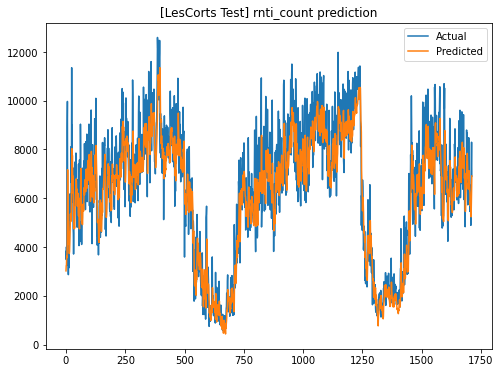

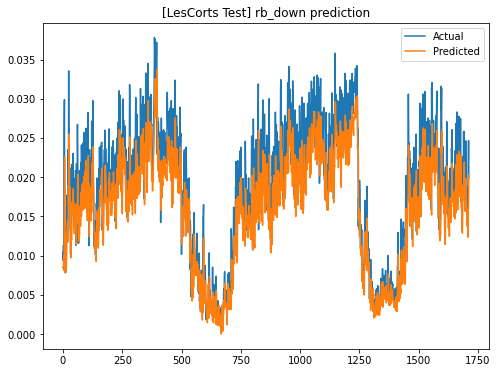

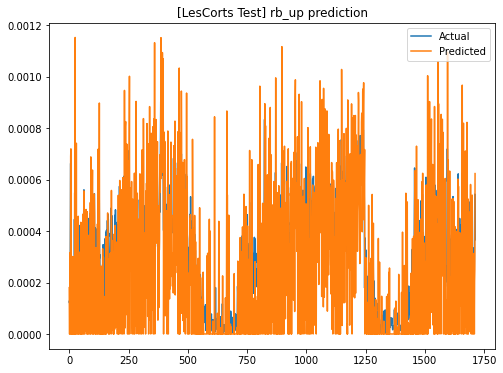

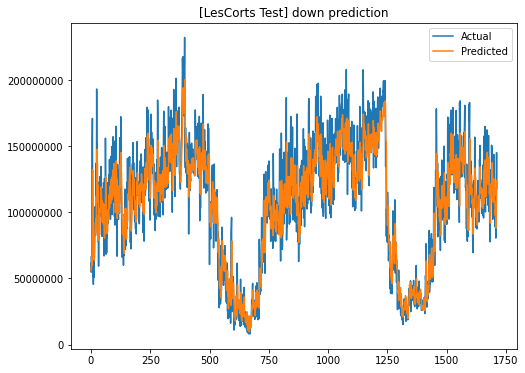

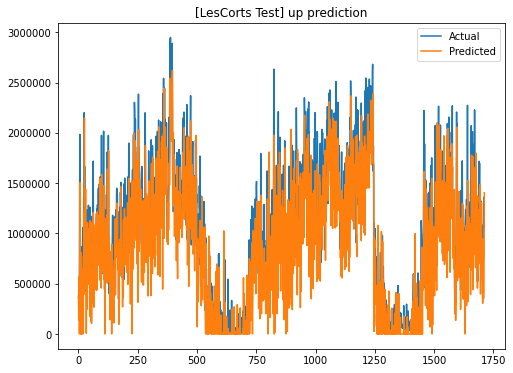

c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
INFO logger 2022-10-25 12:13:37,413 | helpers.py:60 | Metrics for dimension: 0
	mse: 3924939.5, rmse: 1981.146006734486, mae: 1331.30224609375, r^2: 0.7375519742239454, nrmse: 0.2407315632040283
INFO logger 2022-10-25 12:13:37,416 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0011849231086671352, rmse: 0.0344227121050497, mae: 0.013491353020071983, r^2: 0.6527907865739561, nrmse: 0.736431216088575
INFO logger 2022-10-25 12:13:37,417 | helpers.py:60 | Metrics for dimension: 2
	mse: 3.047696554858703e-05, rmse: 0.005520594673455662, mae: 0.0018233757000416517, r^2: 0.681405619587089, nrmse: 1.172516360

Final Prediction in ElBorn
[Test]: mse: 1559858302156800.0, rmse: 39495041.48822735, mae 9088627.0, r2: 0.6589342919212988, nrmse: 0.8816392653762611




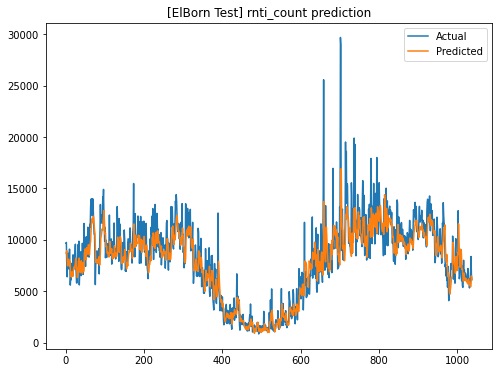

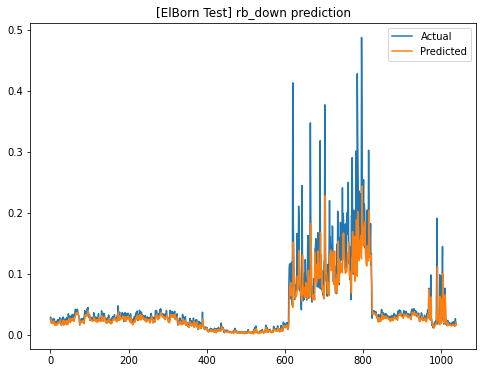

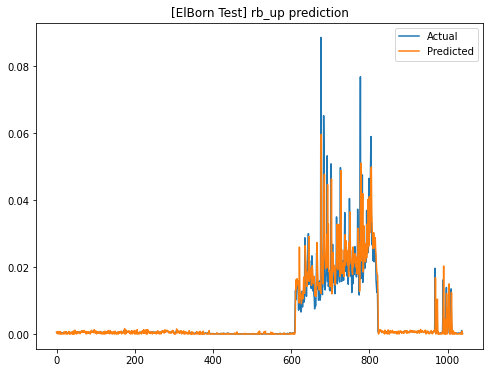

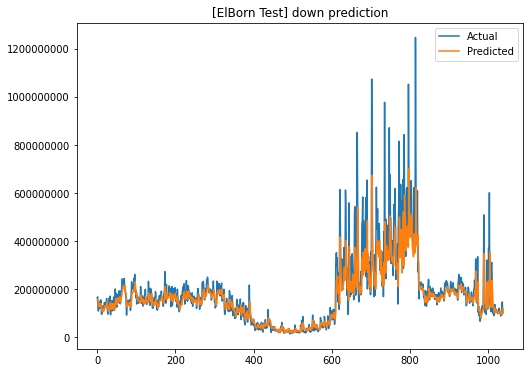

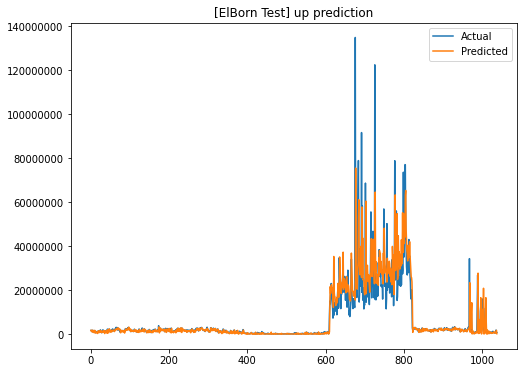

c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
INFO logger 2022-10-25 12:13:43,167 | helpers.py:60 | Metrics for dimension: 0
	mse: 4074926.5, rmse: 2018.644718616924, mae: 1414.11279296875, r^2: 0.4149365801842091, nrmse: 0.3401089142180131
INFO logger 2022-10-25 12:13:43,170 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0013956063194200397, rmse: 0.0373578147034866, mae: 0.016168680042028427, r^2: 0.6485429413953876, nrmse: 0.7692276792837193
INFO logger 2022-10-25 12:13:43,172 | helpers.py:60 | Metrics for dimension: 2
	mse: 0.00012032019731123, rmse: 0.010969056354638261, mae: 0.003813100280240178, r^2: 0.6865214627742863, nrmse: 1.0462191579

Final Prediction in PobleSec
[Test]: mse: 1414205223731200.0, rmse: 37605920.06228807, mae 9763267.0, r2: 0.6007528329644497, nrmse: 0.8391741808962184




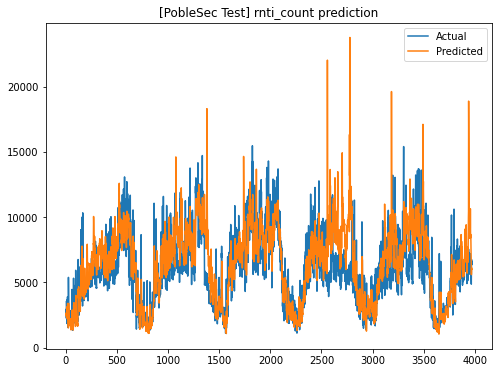

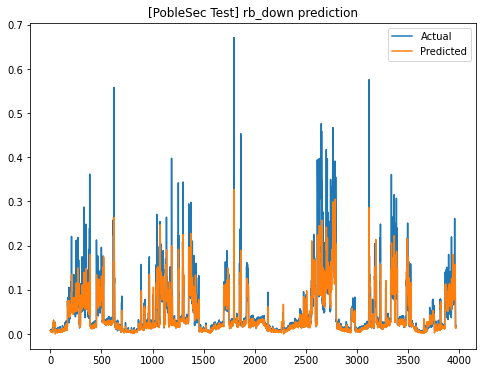

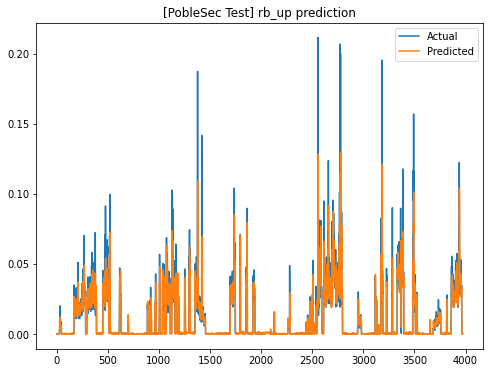

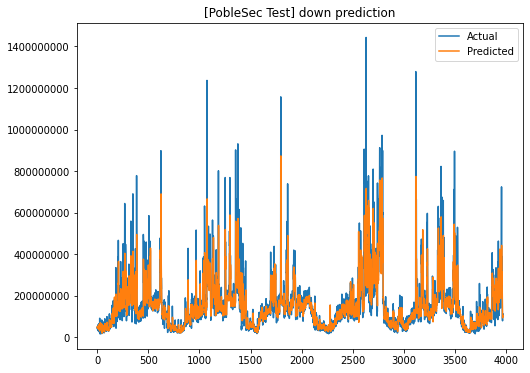

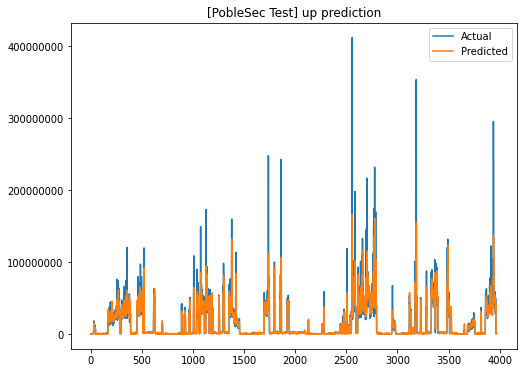

In [22]:
model_test(
    model, 
    test_data_paths,
    x_scaler, 
    y_scaler,
    round_predictions=True
)